# Day 5: Workflows

+ In this notebook, we are going to start learning about `workflows` using Langgraph.

>Workflows are systems where LLMs and tools are orchestrated through predefined code paths. [Building effective agents](https://www.anthropic.com/engineering/building-effective-agents)

What this means is that unlike Agents. Workflows are specific step-by-step instructions of how you intend the LLM to execute your pipeline.

### Step 1: Simple Workflow

In [1]:
import os
from typing import Annotated
from pydantic import BaseModel
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

from IPython.display import Image, display

from dotenv import load_dotenv
load_dotenv()

True

In [21]:
openai_api_key = os.environ.get("OPENAI_API_KEY")
openai_organization = os.environ.get("OPENAI_ORGANIZATION")
tavily_api_key = os.environ.get("TAVILY_API_KEY")

In [3]:
class State(TypedDict):
    messages: str
    name: str
    my_input: str

In [4]:
def my_first_node(state: State):    
    
    state["messages"] = "Hello, " + state["name"] + "."
    
    return {"messages": state["messages"]}

def my_second_node(state: State):
    
    state["messages"] += " " + state["my_input"]
    
    return {"messages": state["messages"]}

In [5]:
workflow_1 = StateGraph(State)

workflow_1.add_node("my_first_node", my_first_node)
workflow_1.add_node("my_second_node", my_second_node)

workflow_1.add_edge(START, "my_first_node")
workflow_1.add_edge("my_first_node", "my_second_node")
workflow_1.add_edge("my_second_node", END)

graph = workflow_1.compile()

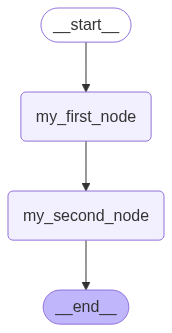

In [6]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"name":"Andronik", "my_input": "What can I help you with?"})

{'messages': 'Hello, Andronik. What can I help you with?',
 'name': 'Andronik',
 'my_input': 'What can I help you with?'}

### Step 2: Workflow

In [8]:
class State(TypedDict):
    messages: str

In [9]:
def to_upper(state: State) -> State:
    """Node 1 – make the string uppercase."""

    state["messages"] = state["messages"].upper()
    
    return {"messages": state["messages"]}

def reverse_text(state: State) -> State:
    """Node 2 – reverse the characters."""

    state["messages"] = state["messages"][::-1]
    
    return {"messages": state["messages"]}

def add_suffix(state: State) -> State:
    """Node 3 – add a friendly suffix and finish."""
    
    state["messages"] = state["messages"] + " 🤖"
    
    return {"messages": state["messages"]}

In [10]:
workflow_2 = StateGraph(State)

workflow_2.add_node("uppercase", to_upper)
workflow_2.add_node("reverse",   reverse_text)
workflow_2.add_node("suffix",    add_suffix)

workflow_2.add_edge("uppercase", "reverse")
workflow_2.add_edge("reverse",   "suffix")
workflow_2.add_edge(START, "uppercase")
workflow_2.add_edge("suffix", END)

graph = workflow_2.compile()

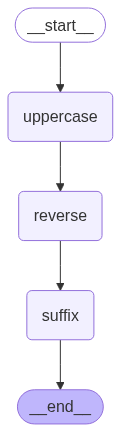

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
graph.invoke({"messages":"Andronik"})

{'messages': 'KINORDNA 🤖'}

### Step 3: Conditional Edges

In [13]:
class QuestionClassification(BaseModel):
    classification: Literal[1, 2, 3]
    reasoning: str

In [14]:
class State(TypedDict):
    question: str
    classification: int
    answer: str

In [22]:
def question_classification(state: State) -> State:
    llm = ChatOpenAI(
        openai_api_key=openai_api_key, 
        openai_organization=openai_organization,
        model="gpt-4o-mini"
    )
    
    structured_llm = llm.with_structured_output(QuestionClassification)
    
    question = state["question"]
    
    prompt = f"""
    Classify the following question into one of three categories:
    1 - Calculator/Math: Questions requiring mathematical calculations
    2 - RAG: Questions that need information retrieval from documents/knowledge base
    3 - Search: Questions requiring web search or current information
    
    Question: {question}
    
    Provide your classification as a number (1, 2, or 3) and brief reasoning.
    """
    
    result = structured_llm.invoke(prompt)

    state["classification"] = result.classification
    
    return {"question": question, "classification": state["classification"]}


def routing_function(state: State) -> Literal["Calculator_Func", "RAG_Func", "Search_Func"]:

    if state["classification"] == 1:
        return "Calculator_Func"
    
    if state["classification"] == 2:
        return "RAG_Func"
    
    if state["classification"] == 3:
        return "Search_Func"
    
    return "Search_Func"

# Tools -----------------------------------------------------------------------------
@tool
def addition(x: int, y: int) -> int:
    """This function is used to add two numbers together and return the result"""
    return x + y

@tool
def vector_search(question: str) -> str:
    """ Function whenever a user is asking about querying my first database """
    embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key,
                                  model="text-embedding-3-large",
                                  chunk_size=1000)
    
    vector_store = Chroma(collection_name="tumo_2025",
                          embedding_function=embeddings,
                          persist_directory="/Users/andronikmk/Documents/Tumo_2025_Summer_Workshop/db/my_first_vdb")
    
    retriever = vector_store.as_retriever(search_kwargs={"k": 10})
    
    return retriever.invoke(question)

# -----------------------------------------------------------------------------------

def calculator(state: State) -> State:
    
    llm = ChatOpenAI(openai_api_key = openai_api_key, 
                     openai_organization = openai_organization,
                     model = "gpt-4o-mini")

    tools = [addition]
    
    agent = create_react_agent(llm, tools=tools)

    response = agent.invoke({"messages": state["question"]})

    state["answer"] = response["messages"][-1].content
    return {"answer": state["answer"]}

def rag(state: State) -> State:
    
    llm = ChatOpenAI(openai_api_key = openai_api_key, 
                     openai_organization = openai_organization,
                     model = "gpt-4o-mini")

    tools = [vector_search]
    
    agent = create_react_agent(llm, tools=tools)

    response = agent.invoke({"messages": state["question"]})

    state["answer"] = response["messages"][-1].content
    
    return {"answer": state["answer"]}

def search(state: State) -> State:
    
    os.environ["TAVILY_API_KEY"] = tavily_api_key

    tavily_search = TavilySearch(max_results=5,
                        topic="general")

    tools = [tavily_search]

    llm = ChatOpenAI(openai_api_key = openai_api_key, 
                     openai_organization = openai_organization,
                     model = "gpt-4o-mini")
    
    agent = create_react_agent(llm, tools)

    response = agent.invoke({"messages": state["question"]})

    state["answer"] = response["messages"][-1].content

    return {"answer": state["answer"]}

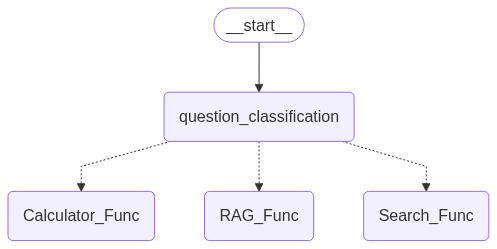

In [23]:
workflow_3 = StateGraph(State)

workflow_3.add_node("question_classification", question_classification)

workflow_3.add_node("Calculator_Func", calculator)
workflow_3.add_node("RAG_Func", rag)
workflow_3.add_node("Search_Func", search)

workflow_3.add_edge(START, "question_classification")
workflow_3.add_conditional_edges("question_classification", routing_function)

graph = workflow_3.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
graph.invoke({"question":"Did Novak win his match at the french open today?"})

{'question': 'Did Novak win his match at the french open today?',
 'classification': 3,
 'answer': 'Yes, Novak Djokovic won his match today at the French Open. He defeated Alexander Zverev with a score of 4-6, 6-3, 6-2, 6-4, advancing to the semifinals where he is set to face Jannik Sinner. You can read more about the match [here](https://www.espn.com/tennis/story/_/id/45452455/novak-djokovic-outlasts-alexander-zverev-reach-french-open-semis).'}

## 🛠️ Hands-On Activity 4 – Build a Smart Router Workflow

In this mini-project you will create a workflow that:
1. **Classifies** the user’s question as either **“math”** (needs calculation) or **“wiki”** (needs a factual lookup).  
2. **Routes** to the correct tool branch:  
   * **Calculator Node** → evaluates the expression and returns the result.  
   * **Wiki Node** → uses an LLM to produce a concise encyclopedic answer.  
3. **Returns** the final answer back to the user.

You’ll practice:
* Writing LangGraph nodes
* Conditional edges
* Combining deterministic Python logic with an LLM call